# ANALYSIS ON THE VEHICLE 13430_109600

In [1]:
vehicle_code = "13430_109600"
stop = "5"

### IMPORT LIBRARIES

In [2]:
# psycopg2 is a library to execute sql queries in python
import psycopg2
# folium allows to visualize geolocalized data with the jupyter notebook
import folium
from folium.plugins import MarkerCluster
# sys is required to use the open function to write on file
import sys
# pandas is needed to read the csv file and to perform some basic operations on dataframes
import pandas as pd
# matplotlib is used to draw graphs
import matplotlib.pyplot as plt
# numpy is for scinetific computations
import numpy as np
# ST_AsGeoJSON returns a json object, so we can use json.load to parse it
import json
# scatter plot with color density
from scipy.stats import gaussian_kde

**WARNING! RUN ONLY ONCE TO SAVE THE CSV FILES!**

**YOU DON'T NEED TO CONNECT TO THE SERVER ONCE YOU ALREADY HAVE THE FILES**

### CONNECT TO THE DATASET

In [3]:
conn = psycopg2.connect("dbname=irpet", host="146.48.83.137", user="sbolgi", password="sbolgi2019", port="5435")

# the cursor allows Python code to execute PostgreSQL command in a database session.
cur = conn.cursor()

In [4]:
# First query: select all trajectories of vehicle 14710_129450
query1 = "SELECT * FROM tak.vodafone_zel1_traj_"+stop+"min WHERE vehicle = '"+ vehicle_code+"'"

# Store result in csv file to perform then other experiments
outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(query1)

with open('../../../datasets/in/Traj'+stop+'min/vehicle_'+vehicle_code+'.csv', 'w', encoding='utf-8') as f:
    cur.copy_expert(outputquery, f)

In [5]:
# Store result in csv file but this time geometry is converted to coordinates

# First query: select all trajectories of vehicle 14710_129450
query1 = """
    SELECT vehicle, tid, ST_AsGeoJSON(traj) as trajcoord, company, vehicletype, length, duration, start_time, end_time
    FROM tak.vodafone_zel1_traj_"""+stop+"min WHERE vehicle = '"+ vehicle_code+"'"

# Store result in csv file to perform then other experiments
outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(query1)

with open('../../../datasets/out/Traj'+stop+'min/vehicle_'+vehicle_code+'_coord.csv', 'w', encoding='utf-8') as f:
    cur.copy_expert(outputquery, f)

In [6]:
conn.close()

###### Open csv just created and execute usual statistics

In [7]:
df = pd.read_csv('../../../datasets/in/Traj'+stop+'min/vehicle_'+vehicle_code+'.csv') 

In [8]:
print("The dataset has", df.shape[0], "rows and", df.shape[1], "columns.")

The dataset has 59385 rows and 9 columns.


In [9]:
df.head(5)

,vehicle,tid,traj,company,vehicletype,length,duration,start_time,end_time
0,13430_109600,15458,01020000A0E6100000BD010000D2A92B9FE5B920404790...,40290,Van,236.252504,11249.0,2017-10-21 16:39:57,2017-10-21 19:47:26
1,13430_109600,5681,01020000A0E6100000050000001630815B77432E406CB4...,40290,Van,0.003108,241.0,2017-08-28 23:41:41,2017-08-28 23:45:42
2,13430_109600,9341,01020000A0E6100000050000005E126745D4943640FF3E...,40290,Van,0.004243,241.0,2017-09-15 05:06:55,2017-09-15 05:10:56
3,13430_109600,12995,01020000A0E610000005000000518369183EC23540DC46...,40290,Van,0.003368,240.0,2017-10-06 22:07:05,2017-10-06 22:11:05
4,13430_109600,15983,01020000A0E61000000500000045B9347EE16D2640A297...,40290,Van,0.002431,240.0,2017-10-26 05:43:53,2017-10-26 05:47:53


In [10]:
print("the vehicle is characterized by 8 fields")
print("tid: has ", len(df["tid"].unique()), "unique values")
print("company: has ", len(df["company"].unique()), "unique values: ", df["company"].unique())
print("vehicletype: has ", len(df["vehicletype"].unique()), "unique values")

the vehicle is characterized by 8 fields
tid: has  59385 unique values
company: has  2 unique values:  ['40290' '\ufeff40290']
vehicletype: has  1 unique values


In [11]:
df[["length", "duration"]].describe()

,length,duration
count,59385.000000,59385.000000
mean,1.328151,381.330067
std,17.540541,1133.981564
min,0.000000,2.000000
25%,0.003284,300.000000
50%,0.004053,300.000000
75%,0.004975,300.000000
max,831.142950,67705.000000


the 90% of the total is  53446.5
the length of the 90% is  0.006122891248066784
the duration of the 90% is  300.0


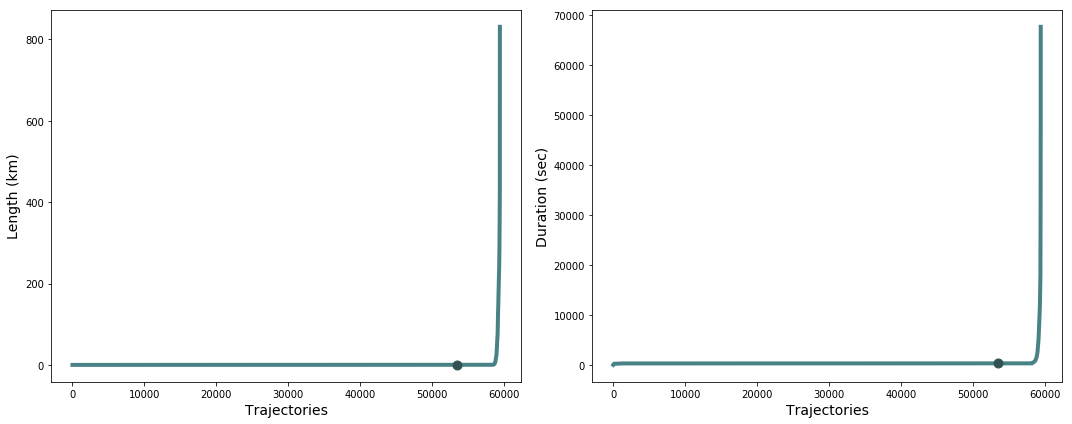

In [12]:
perc90 = (df.shape[0] * 90)/100
print("the 90% of the total is ", perc90)

perc90_i = int(perc90)

print("the length of the 90% is ", sorted(df["length"])[perc90_i])
print("the duration of the 90% is ", sorted(df["duration"])[perc90_i])

fig = plt.figure(figsize=(15, 6)) 
fig_dims = (1, 2)

ax = plt.subplot2grid(fig_dims, (0, 0))
ax.plot(range(0,df.shape[0]), sorted(df["length"]), color='#488286', linewidth=4)
plt.plot(perc90_i, sorted(df["length"])[perc90_i], 'o', color='#305252', markersize=9)
plt.xlabel("Trajectories", fontsize=14)
plt.ylabel("Length (km)", fontsize=14)

ax = plt.subplot2grid(fig_dims, (0, 1))
ax.plot(range(0,df.shape[0]), sorted(df["duration"]), color='#488286', linewidth=4)
plt.plot(perc90_i, sorted(df["duration"])[perc90_i], 'o', color='#305252', markersize=9)
plt.xlabel("Trajectories", fontsize=14)
plt.ylabel("Duration (sec)", fontsize=14)

plt.tight_layout()

plt.savefig('../../../thesis/images/Traj'+stop+'_'+vehicle_code+'_distr.png', format='png', bbox_inches='tight')

### let's zoom on the values "in the area", hence for less than 0.2 km

In [13]:
df_mini = df[df["length"] < 0.2]

The number of trajectories that lasted for less than 200 meters is 58334


C:\Users\Francesca\Anaconda3\lib\site-packages\pandas\core\series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


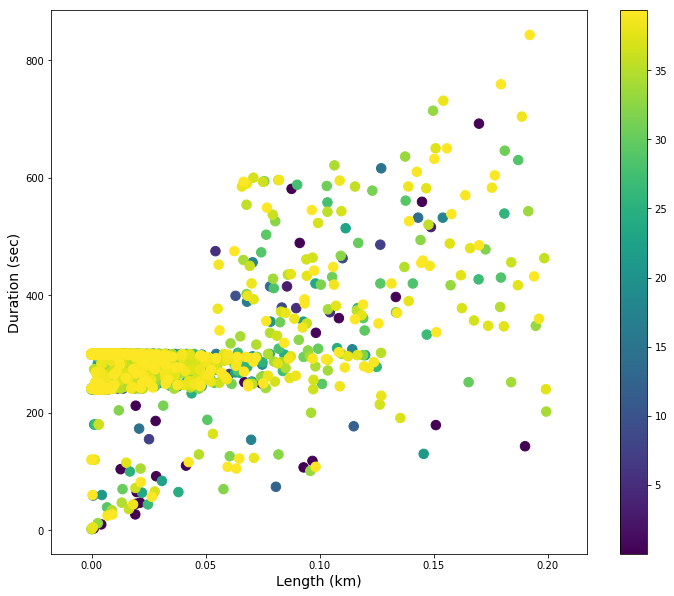

In [14]:
print("The number of trajectories that lasted for less than 200 meters is", df_mini.shape[0])

fig = plt.figure(figsize=(12, 10)) 
fig_dims = (1, 1)

x = df_mini["length"]
y = df_mini["duration"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

ax = plt.subplot2grid(fig_dims, (0, 0))
density = ax.scatter(x, y, c=z, s=90)
fig.colorbar(density)

plt.xlabel("Length (km)", fontsize=14)
plt.ylabel("Duration (sec)", fontsize=14)

plt.savefig('../../../thesis/images/Traj'+stop+'_'+vehicle_code+'_200m.png', format='png', bbox_inches='tight')

## This time we use the csv with the coordinates to try to plot them

In [15]:
df_coord = pd.read_csv('../../../datasets/out/Traj'+stop+'min/vehicle_'+vehicle_code+'_coord.csv') 

In [16]:
def swapXY(traj):
    new_traj = []
    for i in traj:
        new_traj.append([i[1], i[0]])
    return new_traj

In [17]:
coords = []

for el in  df_coord["trajcoord"]:
    y = json.loads(el)
    c = swapXY(y["coordinates"])
    coords.append(c)

In [18]:
df_coord["coord"] = coords
df_coord = df_coord.drop(columns=['vehicle','trajcoord']) 

df_coord.head(5)

,tid,company,vehicletype,length,duration,start_time,end_time,coord
0,15458,40290,Van,236.252504,11249.0,2017-10-21 16:39:57,2017-10-21 19:47:26,"[[44.903433, 8.36308], [44.903433, 8.363075], ..."
1,5681,40290,Van,0.003108,241.0,2017-08-28 23:41:41,2017-08-28 23:45:42,"[[40.926816, 15.13177], [40.926814, 15.13177],..."
2,9341,40290,Van,0.004243,241.0,2017-09-15 05:06:55,2017-09-15 05:10:56,"[[40.332085, 22.581364], [40.332089, 22.581353..."
3,12995,40290,Van,0.003368,240.0,2017-10-06 22:07:05,2017-10-06 22:11:05,"[[38.203475, 21.75876], [38.203457, 21.758767]..."
4,15983,40290,Van,0.002431,240.0,2017-10-26 05:43:53,2017-10-26 05:47:53,"[[44.521215, 11.214611], [44.521218, 11.214614..."


The majority of trajectories are not relevant. We can consider all trajectories beaneath a certain threashold just as GPS errors. In particular we consider just trajectories where the _length_ is at least 0.2 km;

In [49]:
#remove trajectories of less than 200 meters
df_long = df_coord[df_coord["length"] > 0.2].copy(deep=True)

In [50]:
print ("Of the total", df_coord.shape[0], "just", df_long.shape[0], "are trajectories are significant")

Of the total 59385 just 1051 are trajectories are significant


In [51]:
df_long.head(5)

,tid,company,vehicletype,length,duration,start_time,end_time,coord
0,15458,40290,Van,236.252504,11249.0,2017-10-21 16:39:57,2017-10-21 19:47:26,"[[44.903433, 8.36308], [44.903433, 8.363075], ..."
38,46,40290,Van,12.744923,917.0,2017-07-02 17:53:59,2017-07-02 18:09:16,"[[39.588895, 20.818147], [39.567495, 20.781557..."
59,395,40290,Van,6.451208,766.0,2017-07-19 11:31:41,2017-07-19 11:44:27,"[[40.753479, 22.150808], [40.753515, 22.15081]..."
67,398,40290,Van,5.538516,752.0,2017-07-19 13:02:04,2017-07-19 13:14:36,"[[40.784347, 22.122563], [40.78431, 22.122591]..."
68,399,40290,Van,4.831741,581.0,2017-07-19 13:32:57,2017-07-19 13:42:38,"[[40.760494, 22.148472], [40.760473, 22.148488..."


**The problem is that we can't draw all the trajectories together, it's a computation too heavy**

We can split it for periods of time

In [52]:
print("the first trajectory starts at", min(df_long["start_time"]))
print("the last trajectory finish at", max(df_long["start_time"]))

the first trajectory starts at 2017-07-01 07:27:09
the last trajectory finish at 2018-06-29 13:35:43


In [53]:
df_long.loc[:, 'start_month'] = pd.DatetimeIndex(df_long['start_time']).month

In [54]:
def center_traj(coords):
    sum_x = 0
    sum_y = 0
    for i in coords:
        sum_x += i[0][0]
        sum_y += i[0][1]
    c_x = sum_x / len(coords)
    c_y = sum_y / len(coords)
    return c_x, c_y

**JULY 2017**

In [55]:
df_july = df_long[df_long["start_month"] == 7]

In [56]:
print ("in july this vehicle has", len(df_july), "significant trajectories")

in july this vehicle has 97 significant trajectories


In [57]:
coords = df_july["coord"].tolist()
c_x, c_y = center_traj(coords)

In [58]:
colors = ['gray', 'orange', 'green', 'lightred', 'darkgreen', 'darkblue', 'darkred', 'pink', 
          'lightgrayblack', 'lightblue', 'cadetblue', 'darkpurple', 'lightgreen', 'purple', 'blue', 'red', 'beige']

m = folium.Map(location=[c_x, c_y], zoom_start=8)
for i in range(len(df_july)):
    my_PolyLine=folium.PolyLine(locations=coords[i], weight=5, color=colors[i%17])
    m.add_child(my_PolyLine)
    
mc = MarkerCluster()
for i in range(len(df_july)):
    marker = folium.Marker(location=coords[i][0], popup=i, icon=folium.Icon(color=colors[i%17],icon='play'))
    mc.add_child(marker)
    
    marker = folium.Marker(location=coords[i][-1], popup=i, icon=folium.Icon(color=colors[i%17],icon='stop'))
    mc.add_child(marker)

m.add_child(mc)
m

**JANUARY 2018**

In [29]:
df_jan = df_long[df_long["start_month"] == 1]

In [30]:
print ("in january this vehicle has", len(df_jan), "significant trajectories")

in january this vehicle has 33 significant trajectories


In [31]:
coords = df_jan["coord"].tolist()
c_x, c_y = center_traj(coords)

In [32]:
colors = ['gray', 'orange', 'green', 'lightred', 'darkgreen', 'darkblue', 'darkred', 'pink', 
          'lightgrayblack', 'lightblue', 'cadetblue', 'darkpurple', 'lightgreen', 'purple', 'blue', 'red', 'beige']

m = folium.Map(location=[c_x, c_y], zoom_start=8.4)
for i in range(len(df_jan)):
    my_PolyLine=folium.PolyLine(locations=coords[i], weight=5, color=colors[i%17])
    m.add_child(my_PolyLine)
    
mc = MarkerCluster()
for i in range(len(df_jan)):
    marker = folium.Marker(location=coords[i][0], popup=i, icon=folium.Icon(color=colors[i%17],icon='play'))
    mc.add_child(marker)
    
    marker = folium.Marker(location=coords[i][-1], popup=i, icon=folium.Icon(color=colors[i%17],icon='stop'))
    mc.add_child(marker)

m.add_child(mc)
m